# Set up

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio
from sklearn.decomposition import NMF, DictionaryLearning, PCA
import deepdish as dd

# Model

In [2]:
#Set up model
numComp=2
initPro='nndsvda'
iterations=10000000
tolerance=1e-6
variable="Amplitude"
dimensons=[50,50]
random=0
NMFmodel = NMF(n_components=numComp, init=initPro, random_state=random, max_iter=iterations,tol=tolerance)

# Load Data

In [3]:
#Use this function to convert the old matlab structs to typical python dictionary 
def matextract(matData,subNames=['Pulse1','Pulse2','Pulse3','Pulse4','Pulse5','Pulse6','Pulse7','Pulse8','Pulse9','Pulse10']):

    #Define output dict
    outData={}

    #For each sample
    for sample in matData:

        print('Loading: '+sample)

        #Further define output
        outData[sample]={}

        #Extarct data
        samp=matData[sample]
        ampData=samp.rawData.amp*10**6
        phiData=samp.rawData.phi
        wData=samp.rawData.w
        qData=samp.rawData.Q

        #Extract meta data
        bounds=samp.Processed.bounds.Data
        pulses=samp.Processed.pulses
        #timePer=samp.Processed.timePerDiv
        #coer=samp.Processed.coercive

        numPulses=np.shape(bounds)[0]

        #For each sub 
        for i in range(0,numPulses):

            #Further define output
            outData[sample][subNames[i]]={}

            outData[sample][subNames[i]]['Amplitude']=[]
            outData[sample][subNames[i]]['Phase']=[]
            outData[sample][subNames[i]]['Resonance']=[]
            outData[sample][subNames[i]]['Q']=[]

            #Get the bounds for the pulse
            a=bounds[i,0]-1
            b=bounds[i,1]

            if sample != 'pmn_28pt_100':
                #Make the time axis
                time=np.linspace(0,b-a-1,b-a)
            else:
                #Have to account for the four missing points in 28pt
                timeA=np.linspace(0,15,16)

                steps=max(0,b-a-20+4)

                timeB=np.linspace(20,b-a-1+4,steps)
                time=np.hstack((timeA,timeB))

            #Pull out datah for the pulse in question
            pulseAmpData=ampData[:,a:b]
            pulsePhiData=phiData[:,a:b]
            pulseWData=wData[:,a:b]
            pulseQData=qData[:,a:b]

            outData[sample][subNames[i]]['Amplitude'].append(pulseAmpData)
            outData[sample][subNames[i]]['Amplitude']=np.squeeze(outData[sample][subNames[i]]['Amplitude'])

            outData[sample][subNames[i]]['Phase'].append(pulsePhiData)
            outData[sample][subNames[i]]['Phase']=np.squeeze(outData[sample][subNames[i]]['Phase'])

            outData[sample][subNames[i]]['Resonance'].append(pulseWData)
            outData[sample][subNames[i]]['Resonance']=np.squeeze(outData[sample][subNames[i]]['Resonance'])

            outData[sample][subNames[i]]['Q'].append(pulseQData)
            outData[sample][subNames[i]]['Q']=np.squeeze(outData[sample][subNames[i]]['Q'])

            outData[sample][subNames[i]]['Time']=time


        #Store INFO data
        outData[sample]['INFO']={}

        outData[sample]['INFO']['Voltages_Applied']=pulses
        #outData[sample]['INFO']['TimePerDivision']=timePer
        #outData[sample]['INFO']['Coercive_Voltage']=coer

    return outData


In [4]:
#Import all the data

dataDir="C:/Users/lgriffin39/Documents/Python Scripts/Data"

pmn_02_2017 = sio.loadmat("pmn_02_2017.mat", squeeze_me=True, struct_as_record=False)["pmn_02_2017"]
pmn_03_2017 = sio.loadmat("pmn_03_2017.mat", squeeze_me=True, struct_as_record=False)["pmn_03_2017"]
pmn_10pt = sio.loadmat("pmn_10pt.mat", squeeze_me=True, struct_as_record=False)["pmn_10pt"]
pmn_28pt_100 = sio.loadmat("pmn_28pt_100.mat", squeeze_me=True, struct_as_record=False)["pmn_28pt_100"]
pmn_28pt_111 = sio.loadmat("pmn_28pt_111.mat", squeeze_me=True, struct_as_record=False)["pmn_28pt_111"]
pmn_36pt_001 = sio.loadmat("pmn_36pt_001.mat", squeeze_me=True, struct_as_record=False)["pmn_36pt_001"]
pmn_36pt_111 = sio.loadmat("pmn_36pt_111.mat", squeeze_me=True, struct_as_record=False)["pmn_36pt_111"]
pmn_Otherside = sio.loadmat("pmn_Otherside.mat", squeeze_me=True, struct_as_record=False)["pmn_Otherside"]
pmn_pt_tetra1 = sio.loadmat("pmn_pt_tetra1.mat", squeeze_me=True, struct_as_record=False)["pmn_pt_tetra1"]


#Define a dictionary of the data to fit
allRaw = {"pmn_02_2017": pmn_02_2017, 
                #"pmn_03_2017" : pmn_03_2017, 
                #"pmn_10pt" : pmn_10pt, 
                #"pmn_28pt_100" : pmn_28pt_100, 
                #"pmn_28pt_111" : pmn_28pt_111, 
                "pmn_36pt_001" : pmn_36pt_001, 
                #"pmn_36pt_111" : pmn_36pt_111, 
                #"pmn_Otherside" : pmn_Otherside, 
                "pmn_pt_tetra1" : pmn_pt_tetra1}

allRaw=matextract(allRaw)

Loading: pmn_02_2017
Loading: pmn_36pt_001
Loading: pmn_pt_tetra1


# Accessing data

<IPython.core.display.Javascript object>


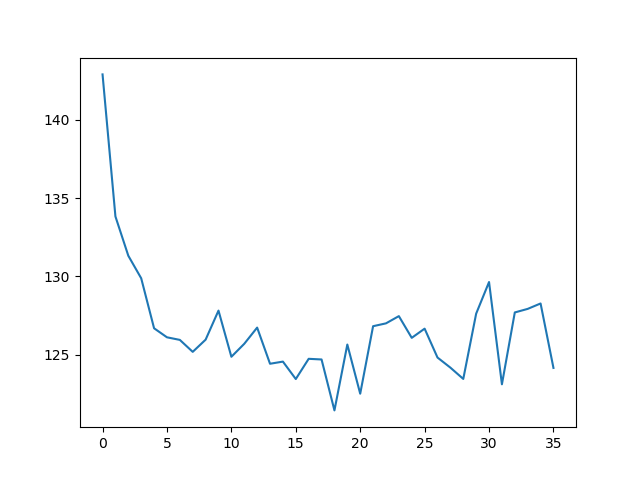

In [5]:
plt.plot(allRaw['pmn_02_2017']['Pulse4']['Amplitude'][230,:])
plt.show()

# Fitting

In [6]:
def func(x, R, A, b, t):                            #
    exponent=(1/t)*x                                #define the function to fit too
    stretch=exponent**b                             # 
    return R * np.exp(-stretch) + A                 #

In [7]:
from scipy.optimize import curve_fit                #Curve fitting function

def fitPoint(time, fitData, func, guess=[1,1,1,1], parms_bound=([-np.inf,-np.inf,0,0],[np.inf,np.inf,1,np.inf]),ftol=1e-8, maxIt=1000):

    #Keep track of failures
    fail=0

    try:
        #Perform the fit
        popt, pcov = curve_fit(func, time, fitData, guess, bounds=parms_bound, maxfev=maxIt, ftol=ftol)

        #Calculate error bars
        perr = np.sqrt(np.diag(pcov))

        ###### Calculate the R squared value #######
        error=(fitData-func(time, *popt))
        var=(fitData-np.mean(fitData))

        res=error**2
        sqVar=var**2

        RSS=np.sum(res)
        TSS=np.sum(sqVar)

        rSq=1-(RSS/TSS)
        ###########################################

    except RuntimeError:
        popt=[np.inf,np.inf,np.inf,np.inf]
        pcov=popt
        perr=pcov
        rSq=np.inf
        ++fail

    return popt,perr,rSq,fail

def matrixFit(time, matrix, func, avgGuess=False, guess=[1,1,1,1], parms_bound=([-np.inf,-np.inf,0,0],[np.inf,np.inf,1,np.inf]),ftol=1e-8, maxIt=1000):

    out={}

    out['Fits']={}
    out['Fits']['Coeffs']=[]
    out['Fits']['Error']=[]
    out['Fits']['RSq']=[]

    #Check the time data
    #If time data is bad. Make some
    timeLen=np.shape(time)[0]

    try:
        matTime=np.shape(matrix)[1]
    except:
        matTime=np.shape(matrix)[0]

    if timeLen != matTime:
        #Make the time info
        time=np.linspace(0,matTime-1,matTime)

    #If desired use the fit of the average of the matrix as the inital guess
    if avgGuess:

        avg=np.mean(matrix, axis=0)
        [avgCoeff,avgPerr,avgRSq,fail]=fitPoint(time, avg, func, guess=guess, parms_bound=parms_bound,ftol=ftol, maxIt=maxIt)

        #Make sure the average fit worked first
        if fail == 0:
            guess=avgCoeff
        else:
            print('Average Fit Failed')

        #Store average fit results
        out['Fits']['Average']={}
        out['Fits']['Average']['Coeffs']=[]
        out['Fits']['Average']['Error']=[]
        out['Fits']['Average']['RSq']=[]

        out['Fits']['Average']['Coeffs'].append(avgCoeff)
        out['Fits']['Average']['Error'].append(avgPerr)
        out['Fits']['Average']['RSq'].append(avgRSq)

    #Count failures
    fails=0

    #Check the size of the data
    numDim=np.shape(np.shape(matrix))[0]

    #Set up output containers
    numCoeff=np.shape(guess)

    #Depending on the size of the data
    #Fit the rows of the matrix or fit the single array
    if numDim > 1:

        numRows=np.shape(matrix)[0]

        coeffs=np.empty(numCoeff,float)
        errors=np.empty(numCoeff,float)
        rSqS=np.empty((1,2),float)

        #For each row, run the fit
        for i in range(0,numRows):

            #Run the point fit
            [coeff,perr,rSq,fail]=fitPoint(time, matrix[i,:], func, guess=guess, parms_bound=parms_bound,ftol=ftol, maxIt=maxIt)

            #Keep track of fails
            fails=fails+fail

            rSq=np.array([rSq,i+1])

            #Temp storage for output
            coeffs=np.vstack((coeffs,coeff))
            errors=np.vstack((errors,perr))
            rSqS=np.vstack((rSqS,rSq))

    else:

        numRows=1

        #Run the point fit
        [coeff,perr,rSq,fail]=fitPoint(time, matrix, func, guess=guess, parms_bound=parms_bound,ftol=ftol, maxIt=maxIt)

        #Keep track of fails
        fails=fails+fail

        #Temp storage for output
        coeffs=coeff
        errors=perr
        rSqS=rSq

    out['Fits']['Coeffs']=coeffs
    out['Fits']['Error']=errors
    out['Fits']['RSq']=rSqS

    failRate=fails/(numRows)

    return out, failRate

#A function that recursively iterates through a dictionary 
#and fits the matricies it finds. The fitter fits the rows of the matrix
def fitDict(fitData, func, time=0, guess=[1,1,1,1], avgGuess=False, parms_bound=([-np.inf,-np.inf,0,0],[np.inf,np.inf,1,np.inf]),ftol=1e-8, maxIt=1000):

    #Check to see if the input is a dictionary or ndarray
    inType=type(fitData)

    dataOut={}

    #If it is not an ndarray, i.e. it is a dictionary
    if inType != np.ndarray:

        #For each key in the dictionary
        for key in fitData:

            #Ignore the INFO, Maps, and more keys
            if key in {'INFO', 'Maps', 'Error', 'Phase', 'Resonance', 'Q', 'Time'}:
                continue

            print('Descending: '+key+'      ', end="\r")

            dataOut[key]={}

            #Go a layer deeper
            newData=fitData[key]

            #Look for stored time info
            if 'Time' in newData:
                time=newData['Time']
            dataOut[key]=fitDict(newData, func, time=time, guess=guess, parms_bound=parms_bound,ftol=ftol, maxIt=maxIt)

        return dataOut

    #If it is an ndarray
    else:

        print('Fitting:    ', end="\r")

        [out,failRate]=matrixFit(time, fitData, func, guess=guess, avgGuess=avgGuess, parms_bound=parms_bound,ftol=ftol, maxIt=maxIt)

        return out

In [10]:
#For example, you can fit the raw data thusly:

fit_results = {}
#for sample in ['pmn_02_2017','pmn_36pt_001','pmn_pt_tetra1']:
fit_results = fitDict(allRaw, func, avgGuess=True)

/home/lgriffin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:166: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


KeyboardInterrupt: 

# Simple NMF

In [ ]:
loading_map = NMFmodel.fit_transform(stack)
components = NMFmodel.components_

# Aggregation

In [30]:
#Voltage aggregation, you can aggregate along time (axis=0) or space (axis=1)
def volt_stitch(allraw, axis = 0):
    out = {}
    
    for sample in ['pmn_02_2017', 'pmn_36pt_001', 'pmn_pt_tetra1']:
        
        sampdata = allraw[sample] 
        out[sample] = []
        ampout = []
        
        for n in np.arange(1,11):
            
            pulsename = 'Pulse'+str(n)
            
            pulsedata = sampdata[pulsename]
            
            amp = pulsedata['Amplitude']
            
            try:
                if axis == 0:
                    ampout = np.hstack([ampout,amp])
                else:
                    ampout = np.vstack([ampout,amp])
            except:
                ampout = amp
            
        out[sample] = ampout
        
    return out

#Sample aggregation, you can aggregate along time (axis=0) or space (axis=1)
def samp_stitch(voltstitch, axis = 1):
    
    ampout = []
    
    for sample in ['pmn_02_2017', 'pmn_36pt_001', 'pmn_pt_tetra1']:

        amp = voltstitch[sample] 

        try:
            if axis == 0:
                ampout = np.hstack([ampout,amp])
            else:
                ampout = np.vstack([ampout,amp])
        except:
            ampout = amp

    return ampout


In [31]:
volt_stitch = volt_stitch(allRaw)
grand_stitch = samp_stitch(volt_stitch)

# NMF w/ Aggregation


In [ ]:
loading_map = NMFmodel.fit_transform(stack)
components = NMFmodel.components_